In [1]:
#Importação das bibliotecas
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RepeatedKFold
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
%matplotlib inline


In [2]:
#Importação dos Datasets
#Fonte: Kaggle
train = pd.read_csv('titanic/trains.csv')
test = pd.read_csv('titanic/test.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Contando valores nulos
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train['Sex'].value_counts(), train['Embarked'].value_counts()

(male      577
 female    314
 Name: Sex, dtype: int64, S    644
 C    168
 Q     77
 Name: Embarked, dtype: int64)

Visualizando os seguintes gráficos por Classe e Gênero, podemos observar que a quantidade de homens mortos é maior que de mulheres, assim como entre as classes.
Logo conclui-se que essas duas variáveis são muito importantes para os modelos de predição.

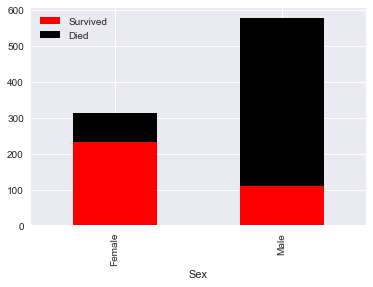

In [6]:
#Quatidade total de mortos e spbreviventes entre os gêneros
train['Died'] = train['Survived'].replace([0,1],[1,0])
train.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar',color=['r','k'],stacked=True).set_xticklabels(['Female','Male'])
plt.show()

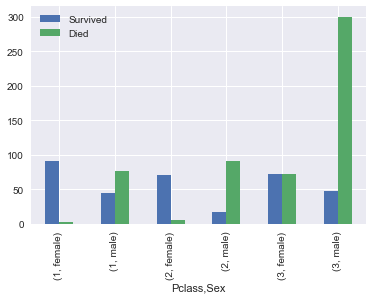

In [7]:
#Quantidade total entre gênero e classe
train.groupby(['Pclass','Sex']).agg('sum')[['Survived','Died']].plot(kind='bar')
plt.show()

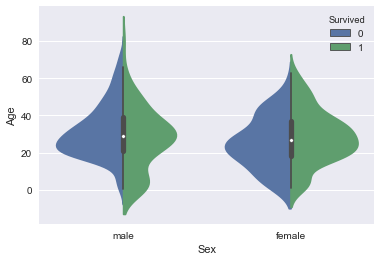

In [8]:
#Relação de sobreviventes entre gênero e idade
sns.violinplot(x='Sex',y='Age',hue='Survived',data=train, split=True)
plt.show()

In [9]:
#Função para aplicar transformações em algumas variáveis
def transf(val1):
    #Transformando valores categóricos em numéricos
    val1['Sex']=val1['Sex'].replace(['female','male'],[1,0])
    val1.update(val1['Embarked'].fillna('S'))
    val1['Embarked'] = val1['Embarked'].replace(['S','Q','C'],[1,2,3])
    #Criando uma coluna com a soma total de integrantes da família, então separando em 4 categorias
    val1['FamSize'] = val1['SibSp'] + val1['Parch'] + 1
    di={1:'Single',2:'Small',3:'Small',4:'Small',5:'Medium',6:'Medium',7:'Large',8:'Large',11:'Large'}
    val1['FamSize'] = val1['FamSize'].map(di)
    val1['FamSize'] = val1['FamSize'].replace(['Single','Small','Medium','Large'],[1,2,3,4])
    #Colhendo as informações dos títulos sociais dos passegeiros para então separa-los por grupos
    title = []
    for i in val1['Name']:
        title.append(i.split(', ')[1].split('.')[0])
    val1['Title'] = title
    val1['title'] = title
    dic={
        'Mr':1,
        'Mrs':2,
        'Miss':3,
        'Master':4,
        'Don':5,
        'Rev':6,
        'Dr':6,
        'Mme':2,
        'Ms':2,
        'Major':6,
        'Lady':5,
        'Sir':5,
        'Mlle':3,
        'Col':6,
        'Capt':6,
        'the Countess':5,
        'Jonkheer':5
    }
    val1['Title'] = val1['Title'].map(dic)
    #Preenchendo os valores faltantes de idade
    val1['Age'] = val1.groupby(['Pclass','Sex','Title'])['Age'].apply(lambda x: x.fillna(x.median()))
    
    #Agrupando os decks do navio pelas Classes
    val1.update(val1['Cabin'].fillna('N'))
    newcab=[]
    for i in val1['Cabin']:
        newcab.append(i[0])
    val1['Cab'] = newcab
    val1['Cab'] = val1['Cab'].replace(['A'], 1)
    val1['Cab'] = val1['Cab'].replace(['B',], 2)
    val1['Cab'] = val1['Cab'].replace(['C'], 3)
    val1['Cab'] = val1['Cab'].replace(['D'], 4)
    val1['Cab'] = val1['Cab'].replace(['E'], 5)
    val1['Cab'] = val1['Cab'].replace(['F'], 6)
    val1['Cab'] = val1['Cab'].replace(['G'], 7)
    val1['Cab'] = val1['Cab'].replace(['N','T'], 8)
    
    val1['Ticket'] = val1['Ticket'].apply(lambda x: int(re.compile(r'\D').sub('',x) + '1'))
    
transf(test)
transf(train)
    
    
    

In [10]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Died           0
FamSize        0
Title          0
title          0
Cab            0
dtype: int64

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died,FamSize,Title,title,Cab
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,5211711,7.2500,N,1,1,2,1,Mr,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,175991,71.2833,C85,3,0,2,2,Mrs,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,231012821,7.9250,N,1,0,1,3,Miss,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,1138031,53.1000,C123,1,0,2,2,Mrs,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,3734501,8.0500,N,1,1,1,1,Mr,8


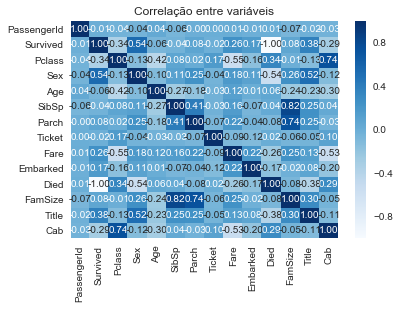

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(train.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis')
plt.show()

In [13]:
x = train[['PassengerId','Age','FamSize','Fare','SibSp','Embarked','Sex','Title','Cab']].fillna(-1)
y = train['Survived']
ts = test[['PassengerId','Age','FamSize','Fare','SibSp','Embarked','Sex','Title','Cab']].fillna(-1)

In [14]:
#algoritmos para testes das predições
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [15]:
#Usando RepeatedKFold para testar qual dos algoritmos possui melhor desempenho em predição com o Dataset
rkf = RepeatedKFold(n_splits=2, n_repeats=10, random_state=10)

In [16]:
resulEx = []
resulKN = []
resulLR = []
resulGa = []
resulRF = []
for linet, linev in rkf.split(x):
    print(linet.shape[0])
    print(linev.shape[0])
    
    xtrain, xvalid = x.iloc[linet], x.iloc[linev]
    ytrain, yvalid = y.iloc[linet], y.iloc[linev]
    
    #ExtraTreesClassifier()
    estimator = ExtraTreesClassifier(n_estimators=100,bootstrap=True)
    estimator.fit(x,y)

    #KNeighborsClassifier()
    estimator1 = KNeighborsClassifier()
    estimator1.fit(x,y)

    #GaussianNB()
    estimator2 = GaussianNB()
    estimator2.fit(x,y)
    
    #LogisticRegression()
    estimator3 = LogisticRegression()
    estimator3.fit(x,y)
    
    #RandomForest()
    estimator4 = RandomForestClassifier()
    estimator4.fit(x,y)
    
    p = estimator.predict(xvalid)
    p1 = estimator1.predict(xvalid)
    p2 = estimator2.predict(xvalid)
    p3 = estimator3.predict(xvalid)
    p4 = estimator4.predict(xvalid)
    
    acc = np.mean(yvalid == p)
    acc1 = np.mean(yvalid == p1)
    acc2 = np.mean(yvalid == p2)
    acc3 = np.mean(yvalid == p3)
    acc4 = np.mean(yvalid == p4)
    
    resulEx.append(acc)
    resulKN.append(acc1)
    resulGa.append(acc2)
    resulLR.append(acc3)
    resulRF.append(acc4)
    print('Acc', acc)
    print('Acc1', acc1)
    print('Acc2', acc2)
    print('Acc3', acc3)
    print('Acc4', acc4)

np.mean(resulEx), np.mean(resulKN), np.mean(resulGa), np.mean(resulLR ), np.mean(resulRF)


    


445
446
Acc 1.0
Acc1 0.77802690583
Acc2 0.798206278027
Acc3 0.811659192825
Acc4 0.977578475336
446
445
Acc 0.997752808989
Acc1 0.741573033708
Acc2 0.78202247191
Acc3 0.784269662921
Acc4 0.984269662921
445
446
Acc 1.0
Acc1 0.780269058296
Acc2 0.795964125561
Acc3 0.811659192825
Acc4 0.970852017937
446
445
Acc 1.0
Acc1 0.739325842697
Acc2 0.784269662921
Acc3 0.784269662921
Acc4 0.988764044944
445
446
Acc 1.0
Acc1 0.77130044843
Acc2 0.784753363229
Acc3 0.798206278027
Acc4 0.986547085202
446
445
Acc 1.0
Acc1 0.748314606742
Acc2 0.795505617978
Acc3 0.797752808989
Acc4 0.988764044944
445
446
Acc 1.0
Acc1 0.780269058296
Acc2 0.807174887892
Acc3 0.795964125561
Acc4 0.97533632287
446
445
Acc 1.0
Acc1 0.739325842697
Acc2 0.773033707865
Acc3 0.8
Acc4 0.988764044944
445
446
Acc 1.0
Acc1 0.757847533632
Acc2 0.791479820628
Acc3 0.789237668161
Acc4 0.979820627803
446
445
Acc 1.0
Acc1 0.761797752809
Acc2 0.788764044944
Acc3 0.806741573034
Acc4 0.995505617978
445
446
Acc 1.0
Acc1 0.744394618834
Acc2 0.7

(0.99966342520280149,
 0.75981483347609213,
 0.79011563460472611,
 0.79797450496296674,
 0.98373079054768997)

Visualizando os resultados e as médias dos mesmos, podemos ver que os algoritmos que se comportaram de melhor maneira foram:
GaussianNB(), LogisticRegression() & RandomForestClassifier()


In [17]:
#Treinando os algoritmos com o Dataset de Treino
gd = pd.read_csv('titanic/gender_submission.csv')
ge = gd['Survived']


estimator2 = GaussianNB()
estimator2.fit(x,y)
p2 = estimator2.predict(ts)

estimator3 = LogisticRegression()
estimator3.fit(x,y)
p3 = estimator3.predict(ts)

estimator4 = RandomForestClassifier()
estimator4.fit(x,y)
p4 = estimator4.predict(ts)

In [18]:
from sklearn.metrics import accuracy_score,confusion_matrix
print('accuracy_score_Gaussian:',accuracy_score(y_true = ge.values, y_pred=p2))
print('accuracy_score_Logistic:',accuracy_score(y_true = ge.values, y_pred=p3))
print('accuracy_score_Random:',accuracy_score(y_true = ge.values, y_pred=p4))

accuracy_score_Gaussian: 0.8995215311
accuracy_score_Logistic: 0.954545454545
accuracy_score_Random: 0.712918660287


GaussianNB
accuracy_score: 0.8995215311


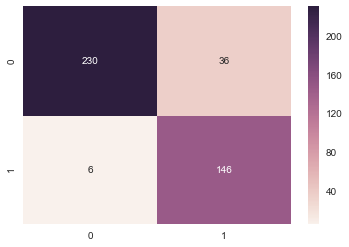

In [19]:
#Visualizando a confusion matrix (valores reaisXvalores previstos)
#accuracy_score

#GaussianNB()
print('GaussianNB')
sns.heatmap(confusion_matrix(y_true = ge.values , y_pred= p2),annot=True,fmt='d')

print('accuracy_score:',accuracy_score(y_true = ge.values, y_pred=p2))

LogisticRegression
accuracy_score: 0.954545454545


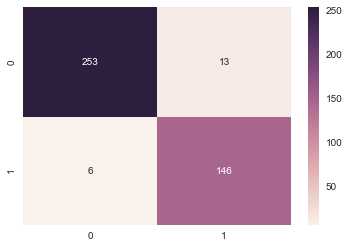

In [20]:
#LogisticRegression()
print('LogisticRegression')
sns.heatmap(confusion_matrix(y_true = ge.values , y_pred= p3),annot=True,fmt='d')

print('accuracy_score:',accuracy_score(y_true = ge.values, y_pred=p3))

RandomForestClassifier
accuracy_score: 0.712918660287


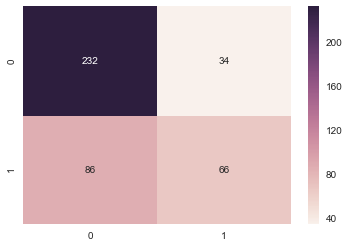

In [21]:
#RandomForestClassifier()
print('RandomForestClassifier')
sns.heatmap(confusion_matrix(y_true = ge.values , y_pred= p4),annot=True,fmt='d')

print('accuracy_score:',accuracy_score(y_true = ge.values, y_pred=p4))